In [14]:
# Built-in
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, TimeDistributed, GlobalAveragePooling2D, LSTM, Dense, Dropout
)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Scikit-learn
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)


In [15]:
# Define the path to the dataset
base_path = '/Users/admin/AIEngineer/DeepFakeProject/Dataset/Faceplus2'
categories = ['fake', 'real']

# Initialize a list to hold data
data = []

# Process each category
for category in categories:
    category_path = os.path.join(base_path, category)
    for filename in os.listdir(category_path):
        if filename.endswith('.jpg'):
            try:
                id_part, frame_part = filename.split('_frame_')
                id_ = id_part.split('_')[0]
                frame = frame_part.split('.')[0]
                data.append({
                    'filename': filename,
                    'path': os.path.join(category_path, filename),
                    'id': int(id_),
                    'frame': int(frame),
                    'label': category
                })
            except ValueError:
                continue

# Convert the data to a DataFrame
df = pd.DataFrame(data)

In [16]:
# Đảm bảo đã có df_cropped.csv chứa đường dẫn ảnh đã crop
df['label_id'] = df['label'].map({'fake': 0, 'real': 1})
df


,filename,path,id,frame,label,label_id
0,596_609_frame_0019.jpg,/Users/admin/AIEngineer/DeepFakeProject/Datase...,596,19,fake,0
1,746_571_frame_0008.jpg,/Users/admin/AIEngineer/DeepFakeProject/Datase...,746,8,fake,0
2,514_443_frame_0028.jpg,/Users/admin/AIEngineer/DeepFakeProject/Datase...,514,28,fake,0
3,642_635_frame_0006.jpg,/Users/admin/AIEngineer/DeepFakeProject/Datase...,642,6,fake,0
4,937_888_frame_0009.jpg,/Users/admin/AIEngineer/DeepFakeProject/Datase...,937,9,fake,0
...,...,...,...,...,...,...
59803,727_frame_0009.jpg,/Users/admin/AIEngineer/DeepFakeProject/Datase...,727,9,real,1
59804,832_frame_0026.jpg,/Users/admin/AIEngineer/DeepFakeProject/Datase...,832,26,real,1
59805,059_frame_0005.jpg,/Users/admin/AIEngineer/DeepFakeProject/Datase...,59,5,real,1
59806,572_frame_0008.jpg,/Users/admin/AIEngineer/DeepFakeProject/Datase...,572,8,real,1


In [17]:
df['video_key'] = df['id'].astype(str) + "_" + df['label']

from collections import defaultdict

video_dict = defaultdict(list)
labels = {}

for _, row in df.iterrows():
    key = row['video_key']
    video_dict[key].append(row['path'])
    labels[key] = row['label_id']


In [7]:
!pip install opencv-python

In [23]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, TimeDistributed, LSTM, Dropout, Dense, GlobalAveragePooling2D, BatchNormalization, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from hmmlearn.hmm import GaussianHMM
from tfkan.layers import Conv2DKAN, DenseKAN  # Import KAN layers
from scipy.stats import mode
from tensorflow.keras.applications import EfficientNetB0


# Giả định đã có
video_keys = list(video_dict.keys())
video_labels = [labels[k] for k in video_keys]

img_size = (224, 224)
batch_size = 32
epochs = 50
n_splits = 5
sequence_len = 10
results = []
all_histories = []

# Data generator
class VideoSequence(tf.keras.utils.Sequence):
    def __init__(self, video_keys, video_dict, labels, batch_size, img_size, sequence_len=10, augment=False):
        self.video_keys = video_keys
        self.video_dict = video_dict
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.sequence_len = sequence_len
        self.augment = augment
        self.datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=15 if augment else 0,
            zoom_range=0.1 if augment else 0,
            horizontal_flip=augment
        )

    def __len__(self):
        return int(np.ceil(len(self.video_keys) / self.batch_size))

    def __getitem__(self, idx):
        batch_keys = self.video_keys[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_X, batch_y = [], []

        for key in batch_keys:
            frames = self.video_dict[key][:self.sequence_len]
            imgs = []
            for path in frames:
                img = cv2.imread(path)
                img = cv2.resize(img, self.img_size)
                img = self.datagen.random_transform(img) if self.augment else img
                img = img.astype('float32') / 255.0
                imgs.append(img)
            while len(imgs) < self.sequence_len:
                imgs.append(np.zeros((*self.img_size, 3), dtype='float32'))
            batch_X.append(imgs)
            batch_y.append(self.labels[key])

        return np.array(batch_X), np.array(batch_y)

# Build model cải tiến
def build_model(sequence_len, img_size):
    base_cnn = MobileNetV2(input_shape=(*img_size, 3), include_top=False, weights='imagenet')

    # Freeze toàn bộ backbone để giảm overfit
    base_cnn.trainable = False

    # CNN feature extractor
    cnn_out = GlobalAveragePooling2D()(base_cnn.output)
    cnn_model = Model(inputs=base_cnn.input, outputs=cnn_out)

    # Sequence input
    input_seq = Input(shape=(sequence_len, *img_size, 3))
    x = TimeDistributed(cnn_model)(input_seq)

    # Temporal modeling
    x = LSTM(64, return_sequences=False)(x)
    x = Dropout(0.5)(x)

    # Classification
    x = DenseKAN(1)(x)
    output = tf.keras.activations.sigmoid(x)

    model = Model(inputs=input_seq, outputs=output)
    return model

# HMM cải tiến
def hmm_postprocess(pred_probs, y_true, n_states=2):
    pred_probs = pred_probs.reshape(-1, 1)
    hmm = GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=100)
    hmm.fit(pred_probs)
    hidden_states = hmm.predict(pred_probs)

    mapping = {}
    for state in np.unique(hidden_states):
        indices = [i for i in range(len(hidden_states)) if hidden_states[i] == state]
        state_labels = [y_true[i] for i in indices]
        if len(state_labels) > 0:
            mapped_label = mode(state_labels, keepdims=True).mode[0]
        else:
            mapped_label = 0  # fallback
        mapping[state] = mapped_label

    hmm_labels = np.array([mapping[s] for s in hidden_states])
    return hmm_labels

# Training K-Fold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for fold, (trainval_idx, test_idx) in enumerate(skf.split(video_keys, video_labels), 1):
    print(f"\n===== Fold {fold} =====")

    trainval_keys = [video_keys[i] for i in trainval_idx]
    test_keys = [video_keys[i] for i in test_idx]

    y_trainval = [labels[k] for k in trainval_keys]
    train_keys, val_keys = train_test_split(trainval_keys, test_size=0.1, stratify=y_trainval, random_state=fold)

    train_gen = VideoSequence(train_keys, video_dict, labels, batch_size, img_size, sequence_len, augment=True)
    val_gen = VideoSequence(val_keys, video_dict, labels, batch_size, img_size, sequence_len, augment=False)
    test_gen = VideoSequence(test_keys, video_dict, labels, batch_size, img_size, sequence_len, augment=False)

    model = build_model(sequence_len, img_size)
    model.compile(optimizer=Adamax(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

    model_path = f"best_model_fold{fold}.h5"
    checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    earlystop = EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

    history = model.fit(train_gen, validation_data=val_gen, epochs=epochs,
                        callbacks=[checkpoint, earlystop, reduce_lr], verbose=1)
    all_histories.append(history.history)

    model.load_weights(model_path)

    y_true = [labels[k] for k in test_keys]
    y_pred_prob = model.predict(test_gen).ravel()
    y_hmm_pred = hmm_postprocess(y_pred_prob, y_true)

    results.append({
        'fold': fold,
        'accuracy': accuracy_score(y_true, y_hmm_pred),
        'precision': precision_score(y_true, y_hmm_pred),
        'recall': recall_score(y_true, y_hmm_pred),
        'f1': f1_score(y_true, y_hmm_pred),
        'auc': roc_auc_score(y_true, y_pred_prob)
    })

print("\n📊 Tổng kết kết quả các fold:")
for r in results:
    print(f"Fold {r['fold']}: Accuracy={r['accuracy']:.4f}, F1={r['f1']:.4f}, AUC={r['auc']:.4f}")



===== Fold 1 =====


Epoch 1/50
45/45 [==============================] - ETA: 0s - loss: 0.6840 - accuracy: 0.5535
Epoch 1: val_accuracy improved from -inf to 0.53125, saving model to best_model_fold1.h5


/opt/anaconda3/envs/environment_tf_216/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - 57s 1s/step - loss: 0.6840 - accuracy: 0.5535 - val_loss: 0.6868 - val_accuracy: 0.5312 - lr: 1.0000e-04
Epoch 2/50
45/45 [==============================] - ETA: 0s - loss: 0.6603 - accuracy: 0.6118
Epoch 2: val_accuracy improved from 0.53125 to 0.57500, saving model to best_model_fold1.h5
45/45 [==============================] - 54s 1s/step - loss: 0.6603 - accuracy: 0.6118 - val_loss: 0.6777 - val_accuracy: 0.5750 - lr: 1.0000e-04
Epoch 3/50
45/45 [==============================] - ETA: 0s - loss: 0.6470 - accuracy: 0.6493
Epoch 3: val_accuracy improved from 0.57500 to 0.60000, saving model to best_model_fold1.h5
45/45 [==============================] - 55s 1s/step - loss: 0.6470 - accuracy: 0.6493 - val_loss: 0.6679 - val_accuracy: 0.6000 - lr: 1.0000e-04
Epoch 4/50
45/45 [==============================] - ETA: 0s - loss: 0.6324 - accuracy: 0.6694
Epoch 4: val_accuracy improved from 0.60000 to 0.63750, saving model to best_model_fold1.h5
45/4

Epoch 1/50
45/45 [==============================] - ETA: 0s - loss: 0.6839 - accuracy: 0.5708
Epoch 1: val_accuracy improved from -inf to 0.63750, saving model to best_model_fold2.h5


/opt/anaconda3/envs/environment_tf_216/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - 54s 1s/step - loss: 0.6839 - accuracy: 0.5708 - val_loss: 0.6659 - val_accuracy: 0.6375 - lr: 1.0000e-04
Epoch 2/50
45/45 [==============================] - ETA: 0s - loss: 0.6612 - accuracy: 0.6153
Epoch 2: val_accuracy did not improve from 0.63750
45/45 [==============================] - 52s 1s/step - loss: 0.6612 - accuracy: 0.6153 - val_loss: 0.6557 - val_accuracy: 0.6250 - lr: 1.0000e-04
Epoch 3/50
45/45 [==============================] - ETA: 0s - loss: 0.6458 - accuracy: 0.6326
Epoch 3: val_accuracy improved from 0.63750 to 0.66875, saving model to best_model_fold2.h5
45/45 [==============================] - 53s 1s/step - loss: 0.6458 - accuracy: 0.6326 - val_loss: 0.6414 - val_accuracy: 0.6687 - lr: 1.0000e-04
Epoch 4/50
45/45 [==============================] - ETA: 0s - loss: 0.6256 - accuracy: 0.6667
Epoch 4: val_accuracy improved from 0.66875 to 0.68125, saving model to best_model_fold2.h5
45/45 [==============================] - 51s 

Epoch 1/50
45/45 [==============================] - ETA: 0s - loss: 0.6964 - accuracy: 0.5319
Epoch 1: val_accuracy improved from -inf to 0.53750, saving model to best_model_fold3.h5


/opt/anaconda3/envs/environment_tf_216/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - 53s 1s/step - loss: 0.6964 - accuracy: 0.5319 - val_loss: 0.6820 - val_accuracy: 0.5375 - lr: 1.0000e-04
Epoch 2/50
45/45 [==============================] - ETA: 0s - loss: 0.6761 - accuracy: 0.5576
Epoch 2: val_accuracy improved from 0.53750 to 0.55625, saving model to best_model_fold3.h5
45/45 [==============================] - 51s 1s/step - loss: 0.6761 - accuracy: 0.5576 - val_loss: 0.6740 - val_accuracy: 0.5562 - lr: 1.0000e-04
Epoch 3/50
45/45 [==============================] - ETA: 0s - loss: 0.6622 - accuracy: 0.5944
Epoch 3: val_accuracy improved from 0.55625 to 0.56250, saving model to best_model_fold3.h5
45/45 [==============================] - 51s 1s/step - loss: 0.6622 - accuracy: 0.5944 - val_loss: 0.6671 - val_accuracy: 0.5625 - lr: 1.0000e-04
Epoch 4/50
45/45 [==============================] - ETA: 0s - loss: 0.6486 - accuracy: 0.6285
Epoch 4: val_accuracy improved from 0.56250 to 0.57500, saving model to best_model_fold3.h5
45/4

Epoch 1/50
45/45 [==============================] - ETA: 0s - loss: 0.7031 - accuracy: 0.5236
Epoch 1: val_accuracy improved from -inf to 0.53125, saving model to best_model_fold4.h5


/opt/anaconda3/envs/environment_tf_216/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - 55s 1s/step - loss: 0.7031 - accuracy: 0.5236 - val_loss: 0.6871 - val_accuracy: 0.5312 - lr: 1.0000e-04
Epoch 2/50
45/45 [==============================] - ETA: 0s - loss: 0.6814 - accuracy: 0.5674
Epoch 2: val_accuracy improved from 0.53125 to 0.55000, saving model to best_model_fold4.h5
45/45 [==============================] - 52s 1s/step - loss: 0.6814 - accuracy: 0.5674 - val_loss: 0.6798 - val_accuracy: 0.5500 - lr: 1.0000e-04
Epoch 3/50
45/45 [==============================] - ETA: 0s - loss: 0.6692 - accuracy: 0.5979
Epoch 3: val_accuracy improved from 0.55000 to 0.60000, saving model to best_model_fold4.h5
45/45 [==============================] - 51s 1s/step - loss: 0.6692 - accuracy: 0.5979 - val_loss: 0.6740 - val_accuracy: 0.6000 - lr: 1.0000e-04
Epoch 4/50
45/45 [==============================] - ETA: 0s - loss: 0.6564 - accuracy: 0.6139
Epoch 4: val_accuracy did not improve from 0.60000
45/45 [==============================] - 51s 

Epoch 1/50
45/45 [==============================] - ETA: 0s - loss: 0.6955 - accuracy: 0.5250
Epoch 1: val_accuracy improved from -inf to 0.60000, saving model to best_model_fold5.h5


/opt/anaconda3/envs/environment_tf_216/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - 57s 1s/step - loss: 0.6955 - accuracy: 0.5250 - val_loss: 0.6703 - val_accuracy: 0.6000 - lr: 1.0000e-04
Epoch 2/50
45/45 [==============================] - ETA: 0s - loss: 0.6744 - accuracy: 0.5813
Epoch 2: val_accuracy improved from 0.60000 to 0.65625, saving model to best_model_fold5.h5
45/45 [==============================] - 54s 1s/step - loss: 0.6744 - accuracy: 0.5813 - val_loss: 0.6580 - val_accuracy: 0.6562 - lr: 1.0000e-04
Epoch 3/50
45/45 [==============================] - ETA: 0s - loss: 0.6613 - accuracy: 0.6014
Epoch 3: val_accuracy improved from 0.65625 to 0.68125, saving model to best_model_fold5.h5
45/45 [==============================] - 55s 1s/step - loss: 0.6613 - accuracy: 0.6014 - val_loss: 0.6464 - val_accuracy: 0.6812 - lr: 1.0000e-04
Epoch 4/50
45/45 [==============================] - ETA: 0s - loss: 0.6494 - accuracy: 0.6326
Epoch 4: val_accuracy improved from 0.68125 to 0.70000, saving model to best_model_fold5.h5
45/4

In [24]:
results_df = pd.DataFrame(results)
print("📊 Kết quả trung bình:")
print(results_df.mean(numeric_only=True))
results_df


📊 Kết quả trung bình:
fold         3.000000
accuracy     0.929500
precision    0.930784
recall       0.933000
f1           0.931142
auc          0.741045
dtype: float64


,fold,accuracy,precision,recall,f1,auc
0,1,0.9925,1.000000,0.985,0.992443,0.783475
1,2,0.9575,1.000000,0.915,0.955614,0.727475
2,3,0.7300,0.714953,0.765,0.739130,0.760875
3,4,1.0000,1.000000,1.000,1.000000,0.749400
4,5,0.9675,0.938967,1.000,0.968523,0.684000


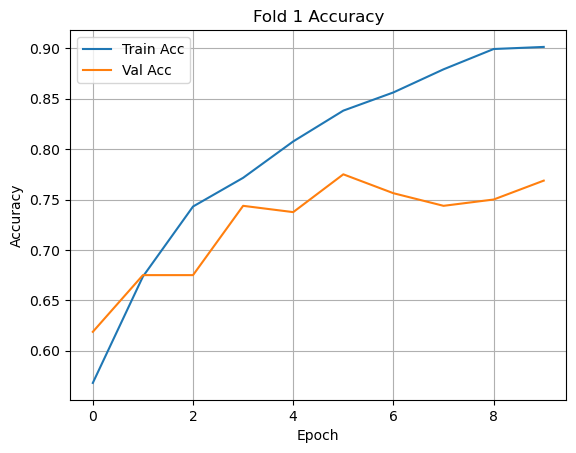

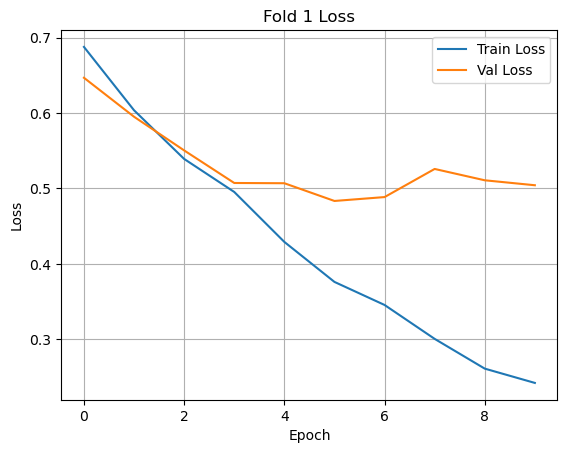

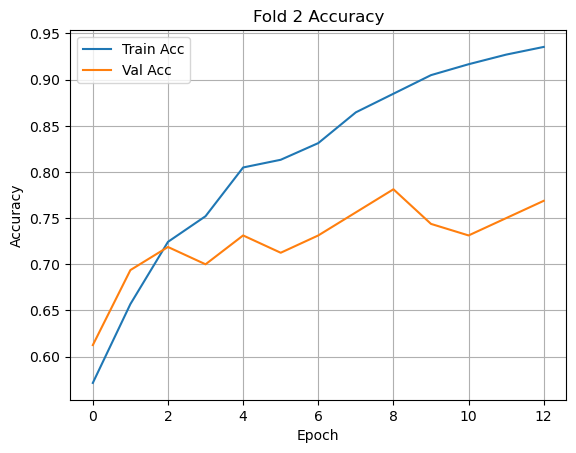

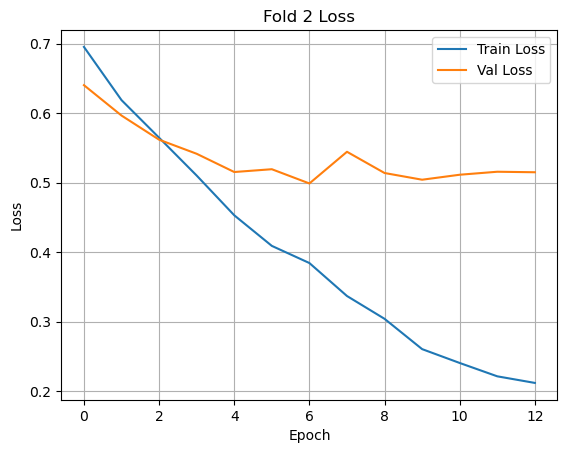

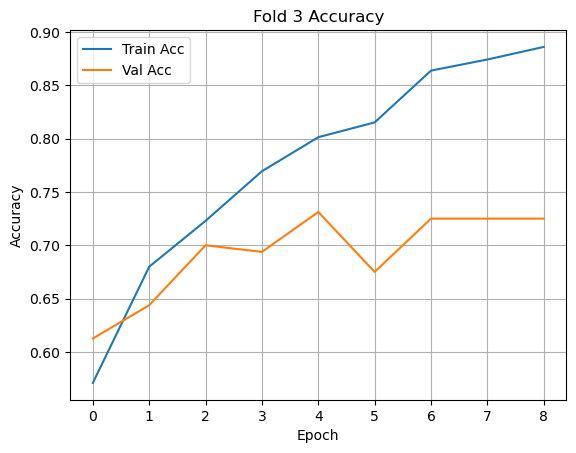

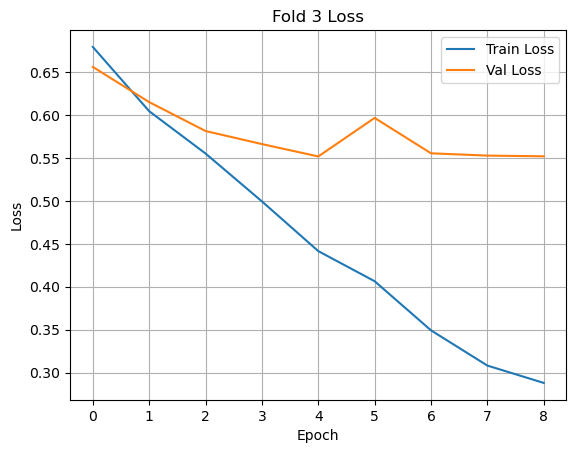

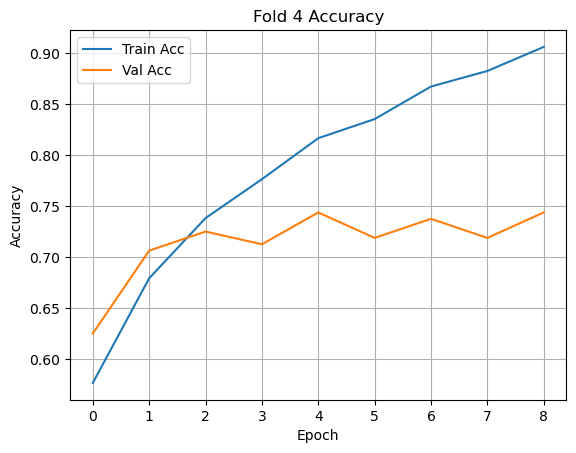

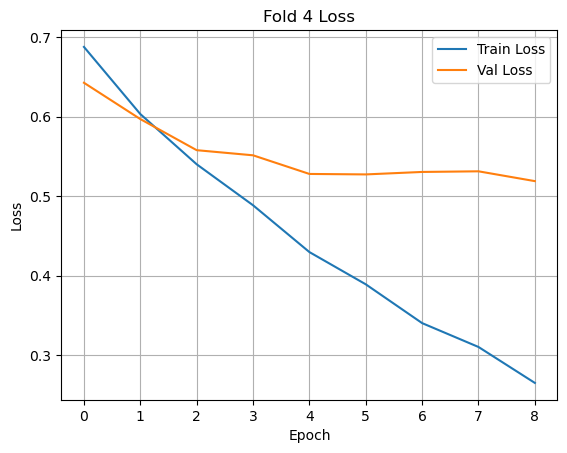

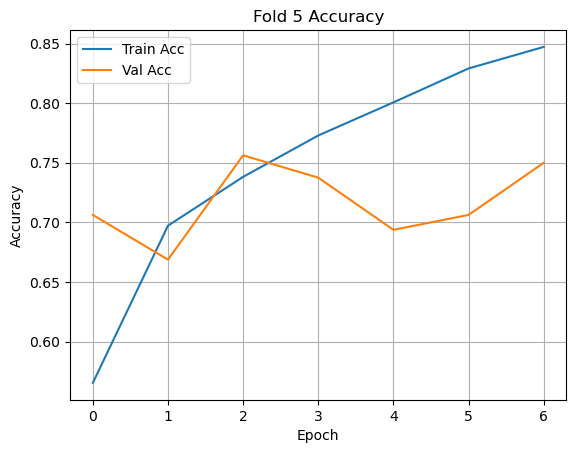

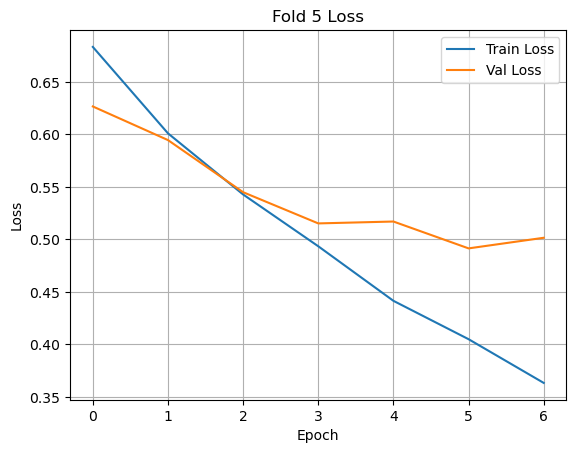

In [8]:
for i, hist in enumerate(all_histories, 1):
    plt.figure()
    plt.plot(hist['accuracy'], label='Train Acc')
    plt.plot(hist['val_accuracy'], label='Val Acc')
    plt.title(f'Fold {i} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(hist['loss'], label='Train Loss')
    plt.plot(hist['val_loss'], label='Val Loss')
    plt.title(f'Fold {i} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


In [9]:
# Save mô hình fold cuối cùng
model.save("mobilenetv2_hmm_faceplus_final.h5")


/opt/anaconda3/envs/environment_tf_216/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
